# Milestone 2 Phase 2

# 1. Perkenalan
Nama : Venu Fitratama

Batch : FTDS-016-RMT

Dataset : Healthy and Deceased Leaves
>`https://www.kaggle.com/datasets/prasanshasatpathy/leaves-healthy-or-diseased`

Objective : 
- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.

# 2. Import Libraries

In [28]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


split-folders tidak tersedia pada google colab sehingga perlu untuk dilakukan instalasi sebelum run pada google colab

In [29]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import ipywidgets as widgets

import os
import pathlib
import glob
import cv2
import splitfolders
import io

from google.colab import files 
from PIL import Image
from IPython.display import display, clear_output
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

# 3. Data Loading

Dataset tidak didownload di local, namun diload langsung menggunakan google colab

In [30]:
# upload file API dari kaggle
files.upload()
# membuat folder di kaggle root
!mkdir -p ~/.kaggle
# copy paste kaggle.json ke folder kaggle
!cp kaggle.json ~/.kaggle
# membuat folder kaggle yang bukan diroot
!mkdir ./kaggle
# memindahkan file kaggle.json ke folder kaggle yang dibuat
!mv ./kaggle.json ./kaggle

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘./kaggle’: File exists


In [31]:
# mengubah perizinan dalam direktori
!chmod 600 ~/.kaggle/kaggle.json
# cek list data yang ada di folder kaggle
!ls ~/.kaggle 

kaggle.json


In [32]:
# download dataset
!kaggle datasets download -d prasanshasatpathy/leaves-healthy-or-diseased --force

100% 6.55G/6.56G [00:48<00:00, 164MB/s]
100% 6.56G/6.56G [00:48<00:00, 146MB/s]


In [33]:
# unzip dataset
!unzip -q /content/leaves-healthy-or-diseased.zip -d images

In [34]:
#cek list direktori
os.listdir('/content/images/leaves_healthy_or_diseased')

['diseased', 'healthy']

In [35]:
base_ds = '/content/images/leaves_healthy_or_diseased'
base_ds = pathlib.Path(base_ds)
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 4502 files [00:55, 81.16 files/s]


In [36]:
# path dataset
main_path = '/content/imgs/'

In [37]:
#path data train, test dan val
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
val_dir = os.path.join(main_path, 'val')

In [38]:
print('train set:')
train_diseased = len(os.listdir(os.path.join(train_dir, 'diseased')))
train_healthy = len(os.listdir(os.path.join(train_dir, 'healthy')))
print(f'jumlah diseased= {train_diseased}')
print(f'jumlah healthy = {train_healthy}')

print('')
print('test set:')
test_diseased = len(os.listdir(os.path.join(test_dir, 'diseased')))
test_healthy = len(os.listdir(os.path.join(test_dir, 'healthy')))
print(f'jumlah diseased= {test_diseased}')
print(f'jumlah healthy = {test_healthy}')

print('')
print('val set:')
val_diseased = len(os.listdir(os.path.join(val_dir, 'diseased')))
val_healthy = len(os.listdir(os.path.join(val_dir, 'healthy')))
print(f'jumlah diseased= {val_diseased}')
print(f'jumlah healthy = {val_healthy}')

train set:
jumlah diseased= 1557
jumlah healthy = 1593

test set:
jumlah diseased= 335
jumlah healthy = 343

val set:
jumlah diseased= 333
jumlah healthy = 341


In [39]:
#mencari file images data train, test, dan val dalam direktori
train_diseased = glob.glob(train_dir+"/diseased/*.JPG")
train_healthy = glob.glob(train_dir+"/healthy/*.JPG")

test_diseased = glob.glob(test_dir+"/diseased/*.JPG")
test_healthy = glob.glob(test_dir+"/healthy/*.JPG")

val_diseased = glob.glob(val_dir+"/diseased/*.JPG")
val_healthy = glob.glob(val_dir+"/healthy/*.JPG")

In [40]:
#fungsi untuk membuat dataframe dari images

def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        # ambil nama dari file \ ke -1
        # images.append(image.split('\')[-1]) 
        # label.append(image.split('\')[-2])
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

In [41]:
#membuat dataframe train, test & val
train_df = create_dataframe(train_diseased + train_healthy)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_diseased + test_healthy)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

val_df = create_dataframe(val_diseased + val_healthy)
val_df = val_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [42]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

train_df.head(5)

(3150, 2)
(678, 2)
(674, 2)


,images,label
0,/content/imgs/train/healthy/0009_0272.JPG,healthy
1,/content/imgs/train/diseased/0013_0208.JPG,diseased
2,/content/imgs/train/healthy/0004_0212.JPG,healthy
3,/content/imgs/train/diseased/0014_0112.JPG,diseased
4,/content/imgs/train/diseased/0014_0080.JPG,diseased


In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  3150 non-null   object
 1   label   3150 non-null   object
dtypes: object(2)
memory usage: 49.3+ KB


- Dataframe train terdiri atas 3150 data.
- Dataframe test terdiri atas 678 data.
- Dataframe val terdiri atas 674 data.
- Tidak ada missing values sebab semua data sama banyaknya antar masing-masing train, test dan val data

# 4. Exploratory Data Analysis (EDA)

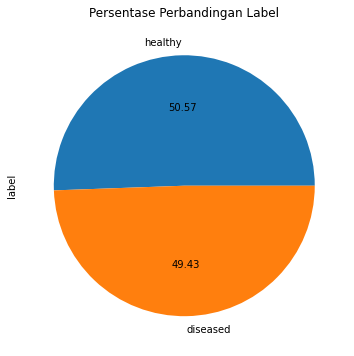

In [44]:
# visualisasi pie chart dari label
train_df['label'].value_counts().plot(kind='pie', figsize=(6,6), autopct='%.2f')
plt.title('Persentase Perbandingan Label')
plt.show()

Jumlah data antara daun yang sehat dan tidak sehat seimbang antar keduanya sehingga kemungkinan ketimpangan akurasi dari hasil test kecil

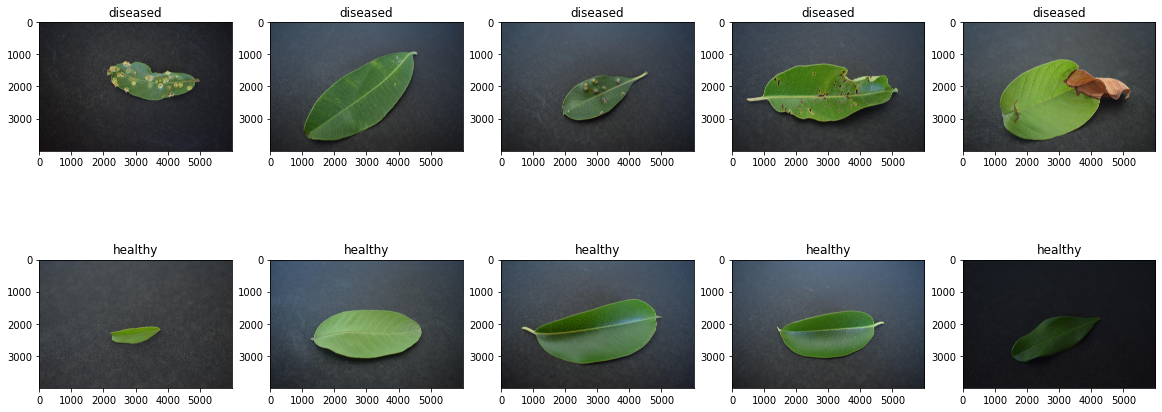

In [45]:
# melihat sampel gambar dari dataset
diseased_samples = (train_df[train_df['label']=='diseased']['images'].iloc[:5]).tolist()
healthy_samples = (train_df[train_df['label']=='healthy']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,8))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(diseased_samples + healthy_samples)

Sample dari 5 gambar daun yang terkena disease dan daun yang sehat menunjukkan bahwa :
- daun yang sehat tidak memiliki bintik-bintik.
- daun yang sehat tidak memiliki bercak hitam.
- daun yang sehat merupakan daun dengan kecerahan warna yang sama dari ujung yang satu ke ujung yang lain.

# 5. Data Preprocessing

### 5.1 Split Fitur dan Target

In [46]:
# fitur
X = 'images'
# target
y= 'label'

### 5.2 Splitting Data Train, Data Test, Data Val

Data telah dipisah sejak data loading, sehingga disini hanya akan mengecek ulang size data

In [47]:
# Tampilkan masing-masing shape
print('Size train: ', train_df.shape)
print('Size validation: ', val_df.shape)
print('Size test: ', test_df.shape)

Size train:  (3150, 2)
Size validation:  (674, 2)
Size test:  (678, 2)


### 5.3 Augmentasi

Tentukan ukuran panjang dan lebar untuk semua image sehingga ukuran input dan output sama, tujuannya untuk mencengah terjadinya error saat data dilakukan training.

Augmentasi merupakan suatu teknik untuk memperluas atau memperbesar data sehingga model dapat melakukan generalisasi. Hal ini dilakukan untuk mencegah adannya overfitting dan model mengenali pola yang bermacam-macam

In [48]:
# definisikan panjang dan lebar
height_img = 180
width_img = 180
# random number
SEED = 23
# jumlah batch
BATCH = 64   

In [49]:
# Augmentasi data 
# Lakukan augmentasi hanya pada train
train_datagen= ImageDataGenerator(
              rescale= 1./255, #rescale
              rotation_range= 0.2, #rotasi
              width_shift_range= 0.2, #menggeser image pada sumbu X (horizontal)
              shear_range= 0.2, #mereganggkan image (bisa vertikal atau horizontal)
              zoom_range= 0.2, #memperbesar
              horizontal_flip= True #pencerminan
              )

# Untuk data validation hanya dilakukan rescale
val_datagen= ImageDataGenerator(rescale= 1./255)

# Untuk data test hanya dilakukan rescale
test_datagen= ImageDataGenerator(rescale= 1./255)

In [50]:
# data train
ds_train= train_datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col= X,
    y_col= y,
    target_size= (height_img,width_img),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= True, #shuffle hanya di data train
    seed= SEED)

# data validation
ds_val= val_datagen.flow_from_dataframe(
    dataframe= val_df,
    x_col= X,
    y_col= y,
    target_size= (height_img,width_img),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED)

# data test
ds_test= test_datagen.flow_from_dataframe(
    dataframe= test_df,
    x_col= X,
    y_col= y,
    target_size= (height_img,width_img),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED)

Found 3150 validated image filenames belonging to 2 classes.
Found 674 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.


In [51]:
#cek label dari class
ds_train.class_indices

{'diseased': 0, 'healthy': 1}

- label 0 digunakan untuk mempresentasikan 'diseased'
- label 1 digunakan untuk mempresentasikan 'healthy'

# 6. Model Definition

Definisikan Model CNN yang akan dibuat dengan menggunakan sequential API

In [52]:
#input size
input = [height_img,width_img,3]

In [53]:
#input size
input = [height_img,width_img,3]

#model
model = Sequential()
#convolution layer
model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape= input))
model.add(MaxPooling2D(pool_size=2, strides=2)) 
# flatten later
model.add(Flatten()) 
model.add(Dense(32))
# hidden layer 1
model.add(Dense(16))
# hidden layer 2
model.add(Dense(8))
# output layer
model.add(Dense(1, activation='sigmoid'))

- Convolution layer merupakan perkalian antara matriks yaitu input dan dan nilai dari filter. Filter yang digunakan adalah 16 dan ouput fitur maps akan menghasilkan ukuran 3x3. Selain itu digunakan pooling atau pengurangan dimensi, hal ini dilakukan untuk mencari informasi fitur yang paling penting. Dimodel ini digunakan hanya 1 layer untuk proses konvolusi untuk feature maps.
- Flatten layer digunakan untuk membentuk ulang feature maps menjadi sebuah vektor, outputnya nanti akan dimasukkan dalam hidden layer.
- Hidden layer pada model digunakan sebanyak 2 layer dengan neuron sebanyak 16 dan 8. Ini merupakan full connected layer yang akan menghitung skor kelas.
- Output layer berarti hasil klasifikasi dari kelas, hanya ada 1 neuron yang digunakan karena merupakan binary clasification yang mana hasilnya antara label 0 atau 1.

In [54]:
#model compile
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
     

- Binary crossentropy digunakan sebab hanya menggunakan 2 jenis klasifikasi (healthy dan diseased).
- optimizer adam dan metrics accuracy digunakan tanpa alasan khusus selain kedua optimizer dan metrics ini umum digunakan.

In [55]:
# summary dari model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dense (Dense)               (None, 32)                4147232   
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                        

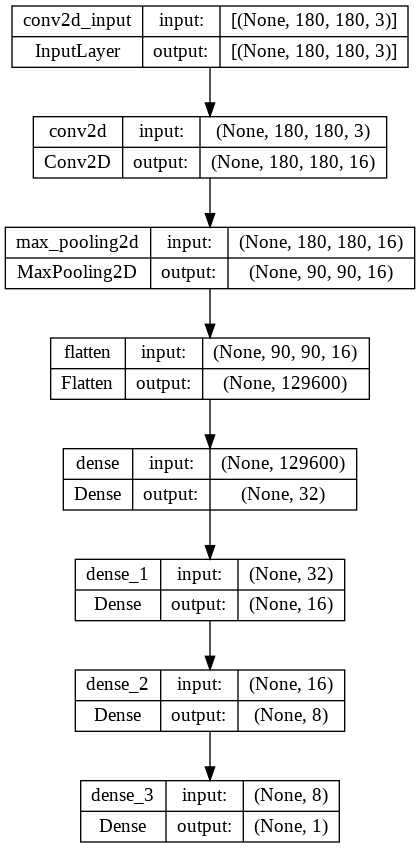

In [56]:
# plot model
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

# 7. Model Training

In [57]:
callbacks= [EarlyStopping(monitor= 'val_loss', mode='min', patience= 5, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='accuracy', save_best_only= True)]

- Early stopping digunakan jika tidak ada peningkatan dari val_loss
- Model checkpoint digunakan agar model menyimpan model terbaik saat dilakukan training.

In [58]:
# training model dengan 10 epoch
history = model.fit(ds_train, 
                    epochs=10, 
                    validation_data=(ds_val),
                    batch_size= BATCH,
                    callbacks= callbacks,
                    verbose=1)

KeyboardInterrupt: ignored

- ETA untuk 1 epochs sekitar 15 menit, digunakan hanya 10 epochs pada running model ke-1 mengingat waktu yang sangat terbatas.

In [ ]:
# ubah ke dataframe
metrics_model = pd.DataFrame(history.history)

# plot loss dan val loss
metrics_model[['loss', 'val_loss']].plot(figsize=(5,5))
plt.title('Perbandingan loss dan validation loss')
plt.show()

In [ ]:
# plot accuracy dan val accuracy
metrics_model[['accuracy', 'val_accuracy']].plot(figsize=(5,5))
plt.title('Perbandingan accuracy dan validation accuracy')
plt.show()

Model tetap berjalan dengan earlystopping dengan gap yang sangat besar pada awal running, namun semakin mengecil semakin mendekati epochs 10, artinya jumlah epochs harus ditambah agar mendapatkan visual dari hasil yang baik dan gap tidak terlalu besar.

# 8. Model Evaluation

In [ ]:
# definisikan label
num_label = ds_train.class_indices

# label dari test
y_test = test_df['label'].copy().map(num_label).astype('int')

In [ ]:

# prediksi data test
ds_test.reset()
y_pred_test = model.predict(ds_test, steps= len(ds_test))
# atur threshold 0.5
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)
# hasil dari classification report
print(classification_report(y_test, y_pred_test))

- Jumlah data seimbang antar label 0 dan label 1, namun pada hasil yang didapat baik itu recall, precision maupun f-1 score sangat timpang antar satu dan lainnya.
- secara keseluruhan jika dilihat dari akurasi dan macro average, tingkat akurasinya hanya 66% & 65% sehingga diperlukan model improvement untuk meningkatkan performa kinerja pada mesin.

# 9. Model Improvement

In [ ]:
# definisikan model
model_imp = Sequential()
# convolution layer
model_imp.add(Conv2D(filters=16, kernel_size=3, padding='same', activation= 'relu', input_shape= input))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))
# convolution layer
model_imp.add(Conv2D(filters=16, kernel_size=3, padding='same', activation= 'relu', input_shape= input))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))
# flatten later
model_imp.add(Flatten())
model_imp.add(Dense(16, activation= 'relu'))
# hidden layer 1
model_imp.add(Dense(8, activation= 'relu'))
model_imp.add(Dropout(rate=0.2))
# output layer
model_imp.add(Dense(1, activation='sigmoid'))

# compile
model_imp.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# training model dengan 20 epoch
history_imp = model_imp.fit(ds_train, 
                    epochs=20, 
                    validation_data=(ds_val),
                    batch_size= BATCH,
                    callbacks= callbacks,
                    verbose=1)

In [ ]:
# ubah ke dataframe
metrics_model_imp = pd.DataFrame(history_imp.history)

# plot loss dan validation loss
metrics_model_imp[['loss', 'val_loss']].plot(figsize=(5,5))
plt.title('Perbandingan loss dan validation loss')
plt.show()

In [ ]:
# plot accuracy dan val_accuracy
metrics_model_imp[['accuracy', 'val_accuracy']].plot(figsize=(5,5))
plt.title('Perbandingan accuracy dan validation accuracy')
plt.show()

- Model menggunakan sequential dengan menambahkan layer convolution layer. Kemudian menambahkan activation function relu pada setiap layer baik pada layer convolution, flatten dan hidden layer.
- Hidden layer hanya ada 1 dan jumlah neuron dikurangi.
- Loss semakin lama semakin mengalami penurunan yang artinya model yang dibangun sudah baik. 
- Namun, untuk val_loss masih mendapatkan hasil yang turun naik.
- Terjadi peningkatan pada akurasi, namun sayangnya untuk val akurasi sendiri masih sangat tidak stabil.

In [ ]:
# definisikan label
num_label = ds_train.class_indices
# label dari test
y_test = test_df['label'].copy().map(num_label).astype('int')

In [ ]:
# prediksi data test
ds_test.reset()
y_pred_test_imp = model_imp.predict(ds_test, steps= len(ds_test))
# atur threshold 0.5
y_pred_test_imp = np.where(y_pred_test_imp >= 0.5, 1, 0)
# hasil dari classification report
print(classification_report(y_test, y_pred_test_imp))

- Hasil dari classification report masih mengalami ketimpangan antara label 0 dan 1, khususnya pada bagian recall.
- Dari akurasi dan macro average, meningkat sebesar 10% dari model sebelumnya yang hanya mendapatkan hasil sebesar 66% & 65%.
- Model masih belum cukup bagus karena tidak stabil.

# 10. Model Inference

In [59]:
# load best model
best_model = load_model('model_best.hdf5')
best_model    

Model saving bukanlah model terbaik yang diambil sebab saya selalu limit jika menggunakan 20 epochs sehingga saya pribadi save manual `model_best.hdf5` dengan 10 epochcs (sudah 4x ganti email, limit running pada GPU)

In [60]:
#fungsi untuk prediksi gambar
def predict_image(upload):
  for name, file_info in uploader.value.items():
    img = Image.open(io.BytesIO(file_info['content']))
  opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
  img = cv2.resize(opencvImage,(180,180))
  img = img.reshape(1,180,180,3)
  a = best_model.predict(img)
  a = np.argmax(a, axis=1)[0]

  if a==1:
    print('Healthy')
  elif a==0:
    print('Diseased')
     

In [61]:
# predict new data
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
  with out:
    clear_output()
    try:
      predict_image(uploader)
    except:
      print('Tidak ada file')

Klik tombol upload untuk upload gambar

In [75]:
# upload button
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

Klik tombol predict untuk prediksi gambar

In [76]:
# prediksi button
button.on_click(on_button_clicked)
widgets.VBox([button, out])

Selain dengan menggunakan image predict, diambil pula data inference dari dataframe train 

In [64]:
# cari data inf 
inf_disease= glob.glob(train_dir+"/diseased/*.JPG")
inf_healthy= glob.glob(train_dir+"/healthy/*.JPG")

In [65]:
# membuat data inference menjadi dataframe
inf_df = create_dataframe(inf_disease + inf_healthy)
inf_df= inf_df.sample(frac=1, random_state=1).reset_index(drop=True)
inf_df

,images,label
0,/content/imgs/train/healthy/0009_0272.JPG,healthy
1,/content/imgs/train/diseased/0013_0208.JPG,diseased
2,/content/imgs/train/healthy/0004_0212.JPG,healthy
3,/content/imgs/train/diseased/0014_0112.JPG,diseased
4,/content/imgs/train/diseased/0014_0080.JPG,diseased
...,...,...
3145,/content/imgs/train/healthy/0009_0119.JPG,healthy
3146,/content/imgs/train/diseased/0022_0086.JPG,diseased
3147,/content/imgs/train/diseased/0016_0077.JPG,diseased
3148,/content/imgs/train/diseased/0021_0070.JPG,diseased


In [66]:
# rescaling
inf_datagen= ImageDataGenerator(rescale= 1./255)

# masukkan dalam dataframe inference
ds_inf= inf_datagen.flow_from_dataframe(
    dataframe= inf_df,
    x_col= X,
    y_col= y,
    target_size= (height_img,width_img),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED)

Found 3150 validated image filenames belonging to 2 classes.


In [67]:
# lakukan prediksi
y_pred_inf = best_model.predict(ds_inf)
# atur threshold untuk klasifikasi
y_pred_inf = np.where(y_pred_inf >= 0.5, 1, 0)

# membuat hasil prediksi menjadi dataframe
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['prediction'])
# konversi value
y_pred_inf_df['prediction'].replace(to_replace=0, value='diseased', inplace=True)
y_pred_inf_df['prediction'].replace(to_replace=1,  value='healthy', inplace=True)

50/50 [==============================] - 897s 18s/step


In [68]:
# Gabungkan data Inference dengan kolom prekdiksi
data_inf_predic = pd.concat([inf_df, y_pred_inf_df], axis=1)
data_inf_predic

,images,label,prediction
0,/content/imgs/train/healthy/0009_0272.JPG,healthy,diseased
1,/content/imgs/train/diseased/0013_0208.JPG,diseased,diseased
2,/content/imgs/train/healthy/0004_0212.JPG,healthy,diseased
3,/content/imgs/train/diseased/0014_0112.JPG,diseased,healthy
4,/content/imgs/train/diseased/0014_0080.JPG,diseased,diseased
...,...,...,...
3145,/content/imgs/train/healthy/0009_0119.JPG,healthy,healthy
3146,/content/imgs/train/diseased/0022_0086.JPG,diseased,diseased
3147,/content/imgs/train/diseased/0016_0077.JPG,diseased,diseased
3148,/content/imgs/train/diseased/0021_0070.JPG,diseased,healthy


In [70]:
print('hasil sebenarnya :')
print(data_inf_predic['label'].value_counts())
print('')
print('hasil prediksi   :')
print(data_inf_predic['prediction'].value_counts())

hasil sebenarnya :
healthy     1593
diseased    1557
Name: label, dtype: int64

hasil prediksi   :
diseased    2000
healthy     1150
Name: prediction, dtype: int64


- Setelah dilakukan percobaan pada data inference, diperlukan peningkatan akurasi sebab masih banyak data yang salah terprediksi.

# 11. Kesimpulan

- Pengujian pada dataset ini bertujuan untuk menggunakan CNN untuk melakukan klasifikasi data (digunakan data binary pada kasus ini) ; untuk mengklasifikasikan daun yang sehat dan tidak sehat.
- Dilakukan pemisahan data train, data test dan validation data saat data loading.
- Data pada jumlah daun sehat dan tidak sehat merupakan data yang seimbang, jumlah perbedaannya sangat kecil, yang mana untuk daun sehat dipresentasikan oleh label 1 dan daun tidak sehat dipresentasikan oleh label 0.
- Daun yang sehat (healthy leaves) merupakan daun hijau yang tidak mempunyai catat pada tekstur yang dapat dilihat mata, sebaliknya daun yang tidak sehat (diseased leaves) merupakan daun yang pada teksturnya tidak sempurna, terdapat bintik-bintik, bercak hitam, ataupun ada sisi daun yang terlihat kering seperti daun mati.
- Pada model basic, tingkat akurasi yang didapat adalah 65%.
- Pada model improvement, tingkat akurasi yang didapat adalah 75%.
- Walaupun didapat hasil klasifikasi yang baik pada `classification report`, namun pada penerapan data inference, dapat dikatakan bahwa model jauh dari kata baik untuk diimplementasikan pada kehidupan nyata.

# ==================== A D D I T I O N A L====================

nb : 
- tidak dilakukan running ulang pada model training & model improvement mengingat waktu yang sangat terbatas serta limit dari google colab sendiri, namun hasil `plot` dan `classification report` pada running ke-1 sudah disimpan oleh penulis untuk dipresentasikan nantinya.
- mohon maaf atas pergantian dataset yang saya lakukan tanpa konfirmasi ulang pada hari sabtu sebab saya pikir kak sardi slowresp saat weekend ; selain itu, saya gagal melakukan model CNN dengan model klasifikasi lebih dari 2 kelas.